# 11wk-2: (순환신경망) – `abc`, `abcd`, 임베딩 공간의 이해, `AbAcAd`, 씨간장

## 1. Imports

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

## 2. 주요 코드 등

### $h$에 대하여 ($\star \star \star$)

`-` $h$는 사실 문자열을 숫자로 바꾼 표현으로 해석할 수 있음. 즉, 원-핫 인코딩과 다른 형태의 숫자표현으로 해석 가능.

* `hidden feature`로서 작용함 -> 학습시켜 생산된 피쳐

`-` 사실 $h$는 원-핫 인코딩보다 약간 더 (1) 액기스만 남은 느낌 + (2) 숙성된 느낌을 준다.

* (why 1) $h$는 $x$보다 $y$를 예측함에 좀 더 직접적인 역할을 한다. 즉, $x$ 숫자보다 $h$ 숫자가 잘 정리되어 있고(차원이 낮고), 입력의 특징을 잘 정리한 의미있는 숫자이다.
* (why 2) $x$는 학습없이 그냥 얻어지는 숫자표현이지만, $h$는 학습을 통하여 고치고 고치고 고치고 고친 숫자표현이다.

`-` 하이퍼볼릭 탄젠트 시그모이드

```Python
net = torch.nn.Sequential(
    torch.nn.Embedding(4, 2),
    torch.nn.Tanh(),
    torch.nn.Linear(2, 4)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(), lr = 0.1)

##---##
for epoc in range(50) :
    netout = net(x)
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()
```

> `(-1, 1)` 범위로 변환 -> 기존 시그모이드는 0에 가까울 경우 `weight`에 둔감했다는 단점을 해소
>
> 여러 개의 은닉 노드로 변환을 더욱 다양화

## 3. 예비학습

`-` 추천 시스템

> (1) MF-based : 표현력이 거의 무한대임 - SVD를 사용
>
> $$\bf X = UDV^{\top} = U^`{V^`}^{\top}$$
>
> * $\bf X$를 예측 매트릭스로 놓고, 몇 개의 피쳐만 사용하면 대부분 맞춰짐 -> 표현력 좋음(피쳐 늘리면 거의 동일하게 만들 수 있음), 오버피팅 방지(몇 개의 피쳐만 사용할 수 있음)
>
> * 이론적으로 우수함
>
> (2) NN-based : underfitting / overfitting을 잘 조절해야 함
>
> * MF에 NN을 결합한 방식이 최종적으로 사용되는 추세임

### **A. `tanh`**

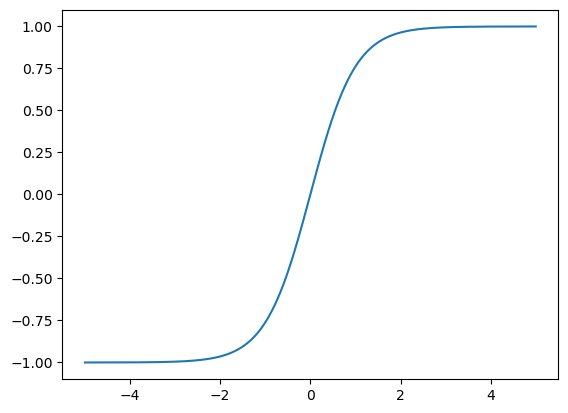

In [2]:
x = torch.linspace(-5, 5, 1001)
tanh = torch.nn.Tanh()
plt.plot(x, tanh(x))

### **B. `softmax`**

In [3]:
logits = torch.randn((10, 5))
logits

tensor([[-0.1008, -2.0929, -1.7614, -1.4641,  2.0948],
        [-1.0485, -0.1599,  0.9150,  0.3184,  0.2256],
        [ 0.3356,  0.7442, -0.7841,  0.6110, -0.2193],
        [ 1.1328, -1.0282, -1.2050, -0.8268,  0.3365],
        [ 0.2271,  0.0067,  0.4769, -0.3265, -0.4487],
        [-0.0344, -1.2913, -0.1834, -1.0950,  1.1767],
        [ 0.0733,  0.2405, -1.0179,  1.5251,  0.3511],
        [ 0.5263, -0.3073, -0.6903,  1.8324,  0.3507],
        [-0.1193,  0.8469, -1.7153, -1.0437, -1.1622],
        [-0.0398,  0.0363, -0.8354,  1.6701, -1.3438]])

In [4]:
# torch.exp(logits)/torch.exp(logits).sum(axis = 1).reshape(-1, 1)
probs = torch.nn.functional.softmax(logits, dim = 1) ## dim == axis라고 보면 됨
probs

tensor([[0.0946, 0.0129, 0.0180, 0.0242, 0.8503],
        [0.0554, 0.1347, 0.3946, 0.2173, 0.1980],
        [0.2118, 0.3186, 0.0691, 0.2789, 0.1216],
        [0.5544, 0.0639, 0.0535, 0.0781, 0.2501],
        [0.2398, 0.1924, 0.3079, 0.1379, 0.1220],
        [0.1710, 0.0486, 0.1473, 0.0592, 0.5739],
        [0.1233, 0.1458, 0.0414, 0.5267, 0.1628],
        [0.1597, 0.0694, 0.0473, 0.5896, 0.1340],
        [0.2183, 0.5738, 0.0443, 0.0866, 0.0770],
        [0.1200, 0.1295, 0.0542, 0.6637, 0.0326]])

## 4. `abc`

### **A. Data**

In [10]:
txt = list('abc'*100)
txt[:10]

['a', 'b', 'c', 'a', 'b', 'c', 'a', 'b', 'c', 'a']

> 다음에 올 단어는...?

`-` 억지로 `X, y` 구조를 생산

In [12]:
df_train = pd.DataFrame({"x" : txt[:-1], "y" : txt[1:]})
df_train[:5]

,x,y
0,a,b
1,b,c
2,c,a
3,a,b
4,b,c


In [13]:
x = torch.tensor(df_train.x.map({'a':0,'b':1,'c':2})) # torch.nn.functional.one_hot() : 임베딩 할거임
y = torch.tensor(df_train.y.map({'a':0,'b':1,'c':2})) # 얘는 파이토치에서 알아서 잘 받아먹음

### **B. MLP - 하나의 은닉노드**

`-` 적합

In [19]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(3, 1),
    torch.nn.Tanh(),
    torch.nn.Linear(1, 3)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(), lr = 0.1)

##---##
for epoc in range(50) :
    netout = net(x)
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [31]:
print(f"acc = {(torch.nn.functional.softmax(net(x), dim = 1).argmax(axis = 1) == y).float().mean().item():.4f}")

acc = 1.0000


`-` 결과 시각화

In [32]:
net

Sequential(
  (0): Embedding(3, 1)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=3, bias=True)
)

In [34]:
ebdd, tanh, linr = net

* `tanh(ebdd(x))` -> a는 0으로, b는 1로, c는 -1로 먹임
* `linr(tanh(ebdd(x)))` -> 가장 큰 값의 axis로 예측

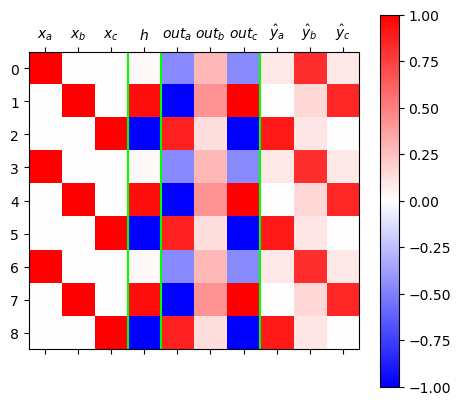

In [63]:
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)) ## (n, 3) + one_hot -> (n, 1) + tanh ## a -> 0 / b -> 1 / c -> -1로 먹임
netout = linr(h) ## net(x)와 동일. (n, 3) -> 가장 빨간 것 : 큰 값으로 예측
yhat = torch.nn.functional.softmax(net(x), dim = 1) ## 확률값
mat = torch.concat([X,h,netout/netout.max(),yhat],axis=1).data

#---#
plt.matshow(mat[:9, :],cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.axvline(2.5,color="lime")
plt.axvline(3.5,color="lime")
plt.axvline(6.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[r"$x_a$",r"$x_b$",r"$x_c$",r"$h$",r"$out_a$",r"$out_b$",r"$out_c$",r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$"]);
plt.show()

`-` 시각화 해석 : 학습이 잘 된 것 같지만, 깔끔하지 않음.

* netout : 가장 빨간 부분이 예측값이 됨
* 문제 1 : $\text{out}_b$의 경우 애매한 색깔만 있음. 네트워크가 해당 범주에 대해선 상대적으로 정답을 잘 모른다는 의미
* 문제 1의 원인 : $\text{out}_b$의 경우 대응하는 $h$가 흰색임 -> 값이 0이기 때문에 $h$에 걸리는 선형 변환의 `weight`가 의미없고, `bias`만 의미있기 때문에 특징을 잡기에 불리함
> 애초에 $h$를 하나만 두었는데, 범주는 세개이니... 구분하기 어려움. 정보를 손실시키는 느낌...

* 문제 2 : $h$가 흰색이면 불리하며, 확실한 색을 가지고 있는 것이 유리함. 그렇지만 확실한 색인 빨강 파랑은 이미 차지된 상태라서 어쩔 수 없이 흰색인 0으로 선택된 것
* 문제 2의 해결 : $a, b, c$의 세 문자열을 표현하기에 범위 $(-1, 1)$는 부적절함...

### **C. MLP - 두 개의 은닉노드**

In [70]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(3, 2),
    torch.nn.Tanh(),
    torch.nn.Linear(2, 3)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(), lr = 0.1)

##---##
for epoc in range(50) :
    netout = net(x)
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [71]:
print(f"acc = {(netout.argmax(axis = 1) == y).float().mean():.4f}")

acc = 1.0000


`-` 결과 시각화

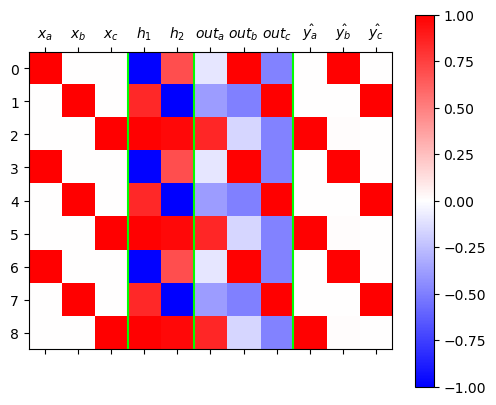

In [75]:
ebdd, tanh, linr = net
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)) ## (n, 3) + one_hot -> (n, 1) + tanh ## a -> 0 / b -> 1 / c -> -1로 먹임
netout = linr(h) ## net(x)와 동일. (n, 3) -> 가장 빨간 것 : 큰 값으로 예측
yhat = torch.nn.functional.softmax(net(x), dim = 1) ## 확률값
mat = torch.concat([X,h,netout/netout.max(),yhat],axis=1).data

#---#
plt.matshow(mat[:9,:] ,cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.axvline(2.5,color="lime")
plt.axvline(4.5,color="lime")
plt.axvline(7.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10],labels=[r"$x_a$", r"$x_b$", r"$x_c$",r"$h_1$",r"$h_2$",r"$out_a$",r"$out_b$",r"$out_c$",r"$\hat{y_a}$",r"$\hat{y_b}$",r"$\hat{y_c}$"]);

`-` 시각화 해석 : 깔끔함. netout의 가장 빨간 부분도 명확함. $h$가 0이 아닌 값으로 학습되어 있음

* `h = (파, 파)`는 사용되지 않음 -> 문자열 하나를 더 쓸 수 있는 공간이 $h$에 있다고 해석할 수 있음.

## 5. `abcd`

### **A. Data**

In [76]:
txt = list('abcd'*100)
txt[:10]

['a', 'b', 'c', 'd', 'a', 'b', 'c', 'd', 'a', 'b']

In [77]:
df_train = pd.DataFrame({'x':txt[:-1], 'y':txt[1:]})
df_train[:5]

,x,y
0,a,b
1,b,c
2,c,d
3,d,a
4,a,b


In [78]:
x = torch.tensor(df_train.x.map({'a':0, 'b':1, 'c':2, 'd':3}))
y = torch.tensor(df_train.y.map({'a':0, 'b':1, 'c':2, 'd':3}))

### **B. MLP - 하나의 은닉노드**

`-` 학습

In [105]:
net = torch.nn.Sequential(
    torch.nn.Embedding(4, 1),
    torch.nn.Tanh(),
    torch.nn.Linear(1, 4)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(), lr = 0.05)

##---##
for epoc in range(100) :
    netout = net(x)
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [107]:
print(f"acc = {(net(x).argmax(axis = 1) == y).float().mean():.4f}")

acc = 1.0000


> 0.5에서 1.0까지 엄청 왔다갔다함.

`-` 결과 시각화

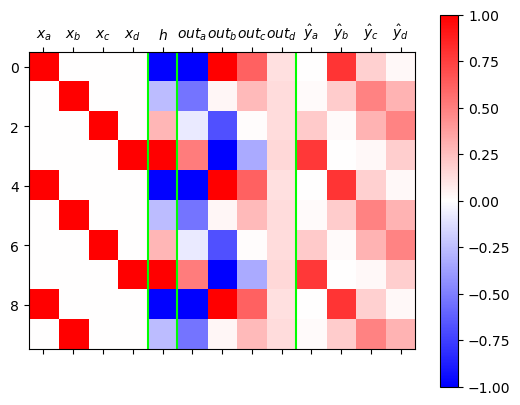

In [108]:
ebdd,tanh,linr = net
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)).data
netout = linr(tanh(ebdd(x))).data
yhat = torch.nn.functional.softmax(net(x),dim=1).data
mat = torch.concat([X,h,netout/netout.max(),yhat],axis=1)
#---#
plt.matshow(mat[:10, :],cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.axvline(3.5,color="lime")
plt.axvline(4.5,color="lime")
plt.axvline(8.5,color="lime")
plt.xticks(
    ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12],
    labels=[
        r"$x_a$",r"$x_b$",r"$x_c$",r"$x_d$",
        r"$h$",
        r"$out_a$",r"$out_b$",r"$out_c$",r"$out_d$",
        r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);

> 초기값이 매우 중요함... 수틀리면 수렴 안해버림...

### **C. MLP - 두 개의 은닉노드**

`-` 학습

In [112]:
net = torch.nn.Sequential(
    torch.nn.Embedding(4, 2),
    torch.nn.Tanh(),
    torch.nn.Linear(2, 4)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(), lr = 0.1)

##---##
for epoc in range(50) :
    netout = net(x)
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [113]:
print(f"acc = {(net(x).argmax(axis = 1) == y).float().mean():.4f}")

acc = 1.0000


`-` 결과 시각화

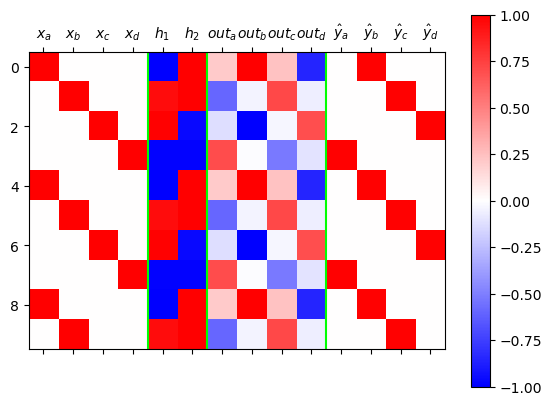

In [114]:
ebdd,tanh,linr = net
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)).data
netout = linr(tanh(ebdd(x))).data
yhat = torch.nn.functional.softmax(net(x),dim=1).data
mat = torch.concat([X,h,netout/netout.max(),yhat],axis=1)
#---#
plt.matshow(mat[:10, :],cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.axvline(3.5,color="lime")
plt.axvline(5.5,color="lime")
plt.axvline(9.5,color="lime")
plt.xticks(
    ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13],
    labels=[
        r"$x_a$",r"$x_b$",r"$x_c$",r"$x_d$",
        r"$h_1$",r"$h_2$",
        r"$out_a$",r"$out_b$",r"$out_c$",r"$out_d$",
        r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);

> 노드 두 개를 쓸 때 훨씬 표현력이 커짐... 당연하지...

### **D. 비교실험**

In [116]:
class Net1(torch.nn.Module) :
    def __init__(self) :
        super().__init__()
        self.ebdd = torch.nn.Embedding(4, 1)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(1, 4)

    def forward(self, X) :
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h)
        return netout

In [115]:
class Net2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ebdd = torch.nn.Embedding(4,2)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(2,4)
        
    def forward(self,X):
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h)
        return netout

`-` 노드가 1개인 네트워크...

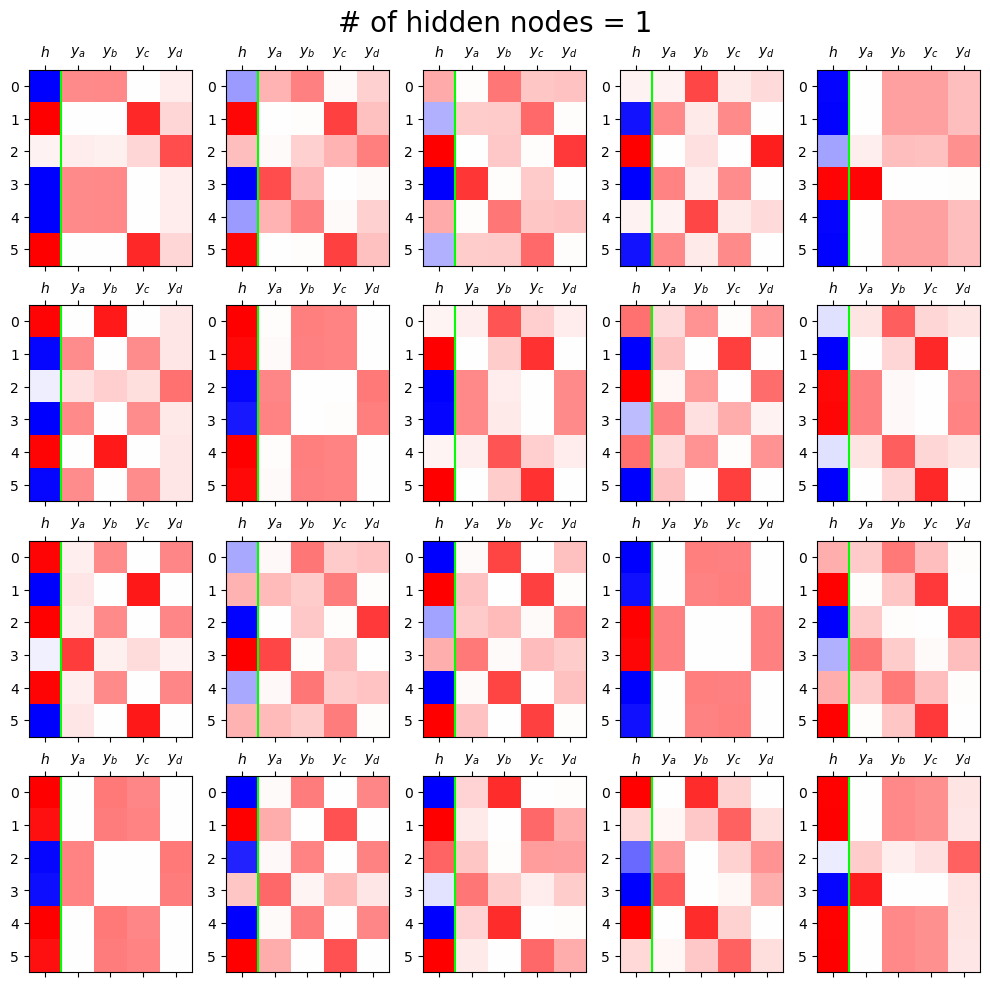

In [119]:
fig, ax = plt.subplots(4,5,figsize=(10,10))
for i in range(4):
    for j in range(5):
        net = Net1()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoc in range(50):
            ## 1 
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data
        yhat = torch.nn.functional.softmax(net(x),dim=1).data
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat[:6, :],cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(0.5,color='lime')
        ax[i][j].set_xticks(ticks=[0,1,2,3,4],labels=[r"$h$",r"$y_a$",r"$y_b$",r"$y_c$",r"$y_d$"])
fig.suptitle("# of hidden nodes = 1", size=20)
fig.tight_layout()

> 된 것은 손에 꼽고, 그 결과도 확실하지 않음.

`-` 노드가 2개인 네트워크의 경우

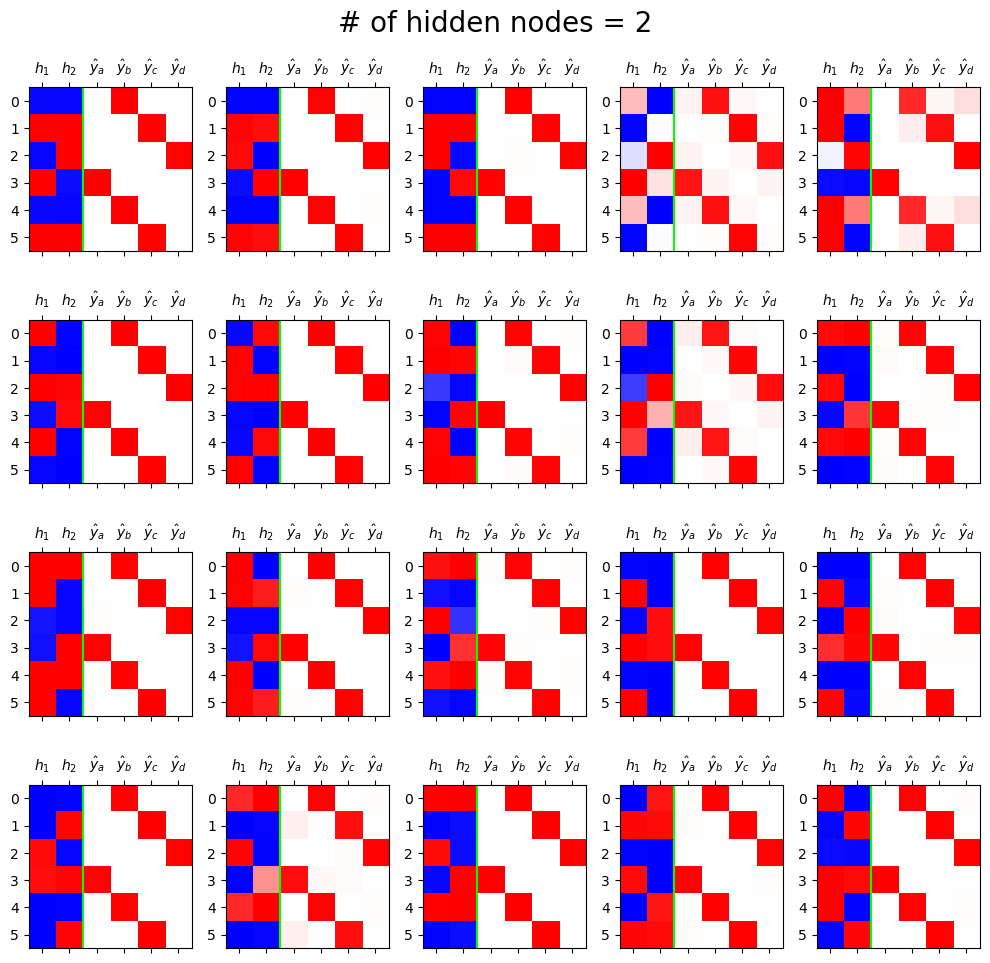

In [120]:
fig, ax = plt.subplots(4,5,figsize=(10,10))
for i in range(4):
    for j in range(5):
        net = Net2()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        loss_fn = torch.nn.CrossEntropyLoss()
        for epoc in range(50):
            ## 1 
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data
        yhat = torch.nn.functional.softmax(net(x),dim=1).data
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat[:6, :],cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(1.5,color='lime')
        ax[i][j].set_xticks(ticks=[0,1,2,3,4,5],labels=[r"$h_1$",r"$h_2$",r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"])
fig.suptitle("# of hidden nodes = 2", size=20)
fig.tight_layout()        

> 가끔 좀 깔끔하지 않은 게 있긴 하지만, 일단 다 성공했고 위보다는 훨씬 나음

## 6. $h$에 대하여 ($\star \star \star$)

`-` $h$는 사실 문자열을 숫자로 바꾼 표현으로 해석할 수 있음. 즉, 원-핫 인코딩과 다른 형태의 숫자표현으로 해석 가능.

* `hidden feature`로서 작용함 -> 학습시켜 생산된 피쳐

`-` 사실 $h$는 원-핫 인코딩보다 약간 더 (1) 액기스만 남은 느낌 + (2) 숙성된 느낌을 준다.

* (why 1) $h$는 $x$보다 $y$를 예측함에 좀 더 직접적인 역할을 한다. 즉, $x$ 숫자보다 $h$ 숫자가 잘 정리되어 있고(차원이 낮고), 입력의 특징을 잘 정리한 의미있는 숫자이다.
* (why 2) $x$는 학습없이 그냥 얻어지는 숫자표현이지만, $h$는 학습을 통하여 고치고 고치고 고치고 고친 숫자표현이다.

## 7. `AbAbAc` - 실패

### **A. Data**

`-` 데이터 정리

In [121]:
txt = list("AbAcAd"*50)
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [123]:
df_train = pd.DataFrame({"x" : txt[:-1], "y" : txt[1:]})
df_train[:5]

,x,y
0,A,b
1,b,A
2,A,c
3,c,A
4,A,d


In [129]:
x = torch.tensor(df_train.x.map({"A":0, "b":1, "c":2, "d":3}))
y = torch.tensor(df_train.y.map({"A":0, "b":1, "c":2, "d":3}))

In [130]:
x[:8], y[:8]

(tensor([0, 1, 0, 2, 0, 3, 0, 1]), tensor([1, 0, 2, 0, 3, 0, 1, 0]))

### **B. 풀이 - 두 개의 은닉노드 : 실패**

`-` 적합

In [131]:
net = torch.nn.Sequential(
    torch.nn.Embedding(4, 2),
    torch.nn.Tanh(),
    torch.nn.Linear(2, 4)
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(), lr = 0.1)

#---#
for epoc in range(100) :
    netout = net(x)
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [134]:
print(f"acc = {(net(x).argmax(axis = 1) == y).float().mean():.4f}")

acc = 0.6656


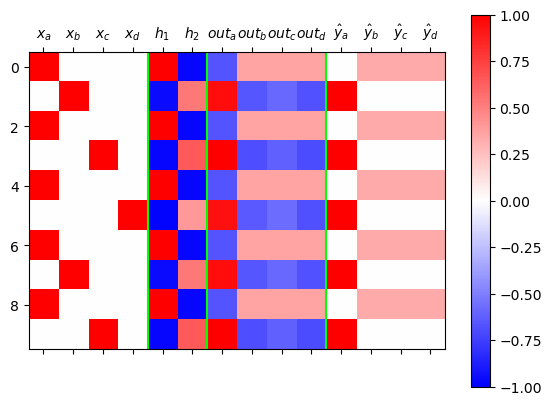

In [135]:
ebdd,tanh,linr = net
X = torch.nn.functional.one_hot(x)
h = tanh(ebdd(x)).data
netout = linr(tanh(ebdd(x))).data
yhat = torch.nn.functional.softmax(net(x),dim=1).data
mat = torch.concat([X,h,netout/netout.max(),yhat],axis=1)
#---#
plt.matshow(mat[:10, :],cmap="bwr",vmin=-1,vmax=1)
plt.colorbar()
plt.axvline(3.5,color="lime")
plt.axvline(5.5,color="lime")
plt.axvline(9.5,color="lime")
plt.xticks(
    ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12,13],
    labels=[
        r"$x_a$",r"$x_b$",r"$x_c$",r"$x_d$",
        r"$h_1$",r"$h_2$",
        r"$out_a$",r"$out_b$",r"$out_c$",r"$out_d$",
        r"$\hat{y}_a$",r"$\hat{y}_b$",r"$\hat{y}_c$",r"$\hat{y}_d$"]
);

> `A`는 잘 구분했음. 근데 그 다음에 뭐가 나올지는 모름...
>
> 노드 수를 늘려도 큰 차이는 없음... 애초에 `AR(1)` 프로세스 느낌이니까 될리가 없지...

### **C. Discussions**

`-` 왜 망함?? - 안드레이 카파시

* `hello`라는 문자열을 맞출 수 있을까? `l` 다음에는 `l`이 나올지, `o`가 나올지 알 수가 없음...
* 앞에 있는 것 하나만 고려하면 맞출 수 없다.

> 이전 시점을 많이 고려하면 맞출 수는 있겠지...
>
> 하지만 이런 방법들(ARMA, N-grams)은 한계가 뚜렷 $\to$ 순환신경망의 등장
>
> 이전 정보가 얼마나 많이 필요한지를 명시할 수 없음...
>
> 과거의 몇 개 정보만으로 모형을 추정하면, 안정성이 떨어짐. 취약함.

## 8. 씨간장

* 간장을 500년 동안 남겨놓음...?